# United States v. Shonubi (1997)

In [34]:
# packages

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive

import pyro.ops.stats as stats
from pyro.infer import Predictive, SVI, Trace_ELBO, TracePredictive
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.nn import PyroSample, PyroModule
from pyro.optim import Adam
from torch import nn
import pyro.poutine as poutine


import os
from functools import partial
import torch
import inspect
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)

%matplotlib inline
plt.style.use('default')

In [19]:
# def run_svi_inference(
#     model,
#     num_steps=500,
#     verbose=True,
#     lr=0.03,
#     guide=None,
#     blocked_sites=None,
#     **model_kwargs,
# ):
#     losses = []
#     # running_loss_means = []
#     if guide is None:
#         guide = AutoMultivariateNormal(pyro.poutine.block(model, hide=blocked_sites))
#     elbo = pyro.infer.Trace_ELBO()(model, guide)

#     elbo(**model_kwargs)
#     adam = torch.optim.Adam(elbo.parameters(), lr=lr)
#     print(f"Running SVI for {num_steps} steps...")
#     for step in range(1, num_steps + 1):
#         adam.zero_grad()
#         loss = elbo(**model_kwargs)
#         loss.backward()
#         losses.append(loss.item())
#         adam.step()
#         if (step % 100 == 0) or (step == 1) & verbose:
#             print("[iteration %04d] loss: %.4f" % (step, loss))

#     plt.figure()
#     plt.plot(losses, label="ELBO loss")
#     sns.despine()
#     plt.title("ELBO Loss")
#     plt.ylim(0, max(losses))
#     plt.legend()
#     plt.show()

#     return guide
   



# def get_samples(
#     distance,
#     proximity,
#     how_far,
#     model= model_sigmavar_proximity,
#     num_svi_iters=num_svi_iters,
#     num_samples=num_samples,
# ):
#     guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
#     svi = SVI(
#         model_sigmavar_proximity, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO()
#     )

#     iterations = []
#     losses = []

#     logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
#     start_time = time.time()
#     pyro.clear_param_store()
#     for i in range(num_svi_iters):
#         elbo = svi.step(distance, proximity, how_far)
#         iterations.append(i)
#         losses.append(elbo)
#         if i % 50 == 0:
#             logging.info("Elbo loss: {}".format(elbo))
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

#     # uncomment if you want to see the ELBO loss plots
#     # fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
#     # labels = {"iterations": "iteration", "losses": "loss"}
#     # fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
#     # fig.update_yaxes(showgrid=False, title_text=labels["losses"])
#     # fig.update_layout(width=700)
#     # fig.show()

#     predictive = Predictive(model, guide=guide, num_samples=num_samples)

#     proximity_svi = {
#         k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
#         for k, v in predictive(distance, proximity, how_far).items()
#         if k != "obs"
#     }

#     print("SVI-based coefficient marginals:")
#     for site, values in ft.summary(proximity_svi, ["d", "p"]).items():
#         print("Site: {}".format(site))
#         print(values, "\n")

#     return {
#         "svi_samples": proximity_svi,
#         "svi_guide": guide,
#         "svi_predictive": predictive,
#     }
    
    

In [35]:
def summary_sample(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "95%"]]
    return site_stats

def precis(samples):

    for site, values in summary_sample(samples).items():
        print("Site: {}".format(site))
        print(values, "\n") 

In [36]:
# the dataset

sh = pd.read_csv('ShonubiCaseDataset.csv')
sh.head(5)

sh.rename(columns={' balloons': 'balloons'}, inplace=True)

FIRST, STRATEGY WHICH USES POSTERIOR MEANS ONLY


note there are 107 cases with gross_wt, but no net_wt. Let's first predict
those, then fill them in to predict weight based on balloons

In [37]:
compData = sh[['gross_wt', 'net_wt']].dropna()

data_gross = torch.tensor(compData[["gross_wt", "net_wt"]].values,
                        dtype=torch.float)

gross_wt, net_wt  = data_gross[:, 0], data_gross[:, 1]
    
    
def model_net1(gross_wt, net_wt = None):
    b_a = pyro.sample("bA", dist.Normal(0.6, 0.3))
    sigma = pyro.sample("sigma", dist.Uniform(0., 150.))
    mean = b_a * gross_wt
    with pyro.plate("data_gross", len(gross_wt)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=net_wt)
        
        

In [38]:
guide_net1 = AutoDiagonalNormal(model_net1)
adam = pyro.optim.Adam({"lr": 0.03})

svi__net1 = SVI(model_net1, guide_net1, adam, loss=Trace_ELBO())




In [40]:
num_iterations = 1500 if not smoke_test else 2

for i in range(num_iterations):
    elbo = svi__net1.step(gross_wt, net_wt)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 778.0695116519928


Elbo loss: 775.4913767576218
Elbo loss: 776.4200291633606


In [41]:
num_samples = 1000
predictive = Predictive(model_net1, guide=guide_net1, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(gross_wt, net_wt).items()
               if k != "obs"}

In [42]:
precis(svi_samples)

#note how the model is pretty certain about where the mean is, but has a
#rather huge sd. If we focus on mean values, we ignore this uncertainty


Site: bA
       mean       std        5%       95%
0  0.615261  0.017997  0.585699  0.644557 

Site: sigma
        mean       std          5%         95%
0  129.10434  4.574763  121.099046  135.533887 



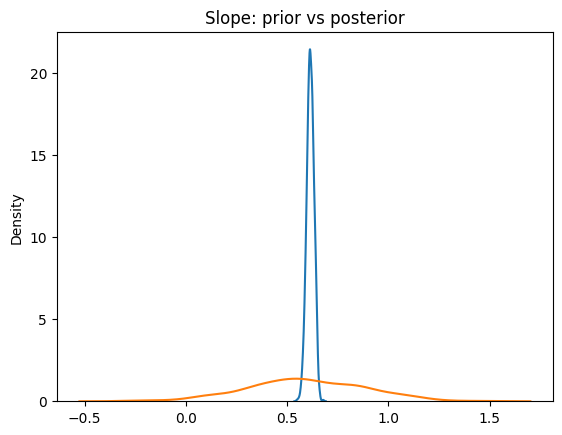

In [43]:
# density plot of a slope

prior_bA = pyro.sample("bA", dist.Normal(0.6, 0.3).expand([500]))

sns.kdeplot(svi_samples['bA'], fill=False)
sns.kdeplot(prior_bA, fill=False)
plt.title('Slope: prior vs posterior')
plt.show()

In [44]:
predictive = Predictive(model_net1, guide=guide_net1, num_samples=num_samples)
samples1 = predictive(gross_wt)
samples1.keys()

dict_keys(['bA', 'sigma', 'obs'])

In [45]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

pred_summary = summary(samples1)

In [46]:
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "gross_wt": gross_wt,
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "net_wt": net_wt,
})

predictions.head()

,gross_wt,y_mean,y_perc_5,y_perc_95,net_wt
0,742.400024,456.362183,248.657349,687.387817,503.200012
1,901.700012,554.851807,349.193237,761.024475,576.900024
2,800.200012,485.037903,275.886810,701.721619,573.299988
3,706.200012,430.569763,207.369019,638.587402,439.799988
4,72.199997,46.329597,-155.256439,261.128845,23.100000


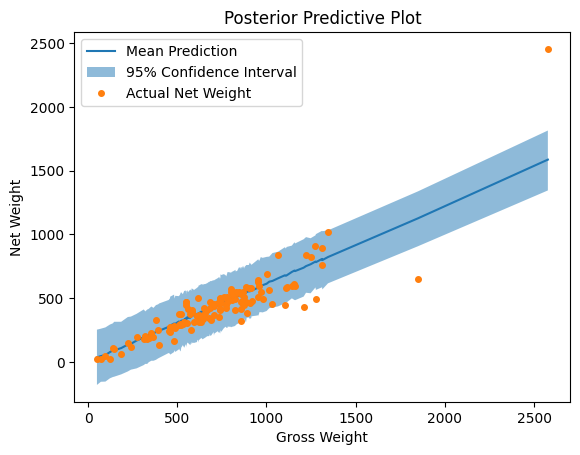

In [47]:

predictions = predictions.sort_values(by=["gross_wt"])

plt.plot(predictions["gross_wt"], predictions["y_mean"], label='Mean Prediction')
plt.fill_between(predictions['gross_wt'],
                  predictions["y_perc_5"],
                    predictions["y_perc_95"], alpha=0.5, label='95% Confidence Interval')
plt.plot(predictions["gross_wt"], predictions["net_wt"], "o",
          markersize=4, label='Actual Net Weight')

plt.title('Posterior Predictive Plot')
plt.xlabel('Gross Weight')
plt.ylabel('Net Weight')
plt.legend()

plt.show()


## Filling missing net values

In [48]:
# taking a subset of missing net_wt values

fillNet = sh.copy()[(~sh['gross_wt'].isna()) & (sh['net_wt'].isna())]
gross_wtFILL = torch.tensor(fillNet["gross_wt"].values, dtype=torch.float)

samples_FILL = predictive(gross_wtFILL)

samples_preds = samples_FILL['obs']
samples_preds_summ = summary(samples_FILL)['obs']


Summary of predictions for missing net weights:

In [49]:
predictions_df = pd.DataFrame({
    "gross_wt": gross_wtFILL,
    "y_mean": samples_preds_summ["mean"],
    "y_perc_5": samples_preds_summ["5%"],
    "y_perc_95": samples_preds_summ["95%"],
})

predictions_df.head()

,gross_wt,y_mean,y_perc_5,y_perc_95
0,331.0,203.219635,-18.165802,416.385864
1,572.0,347.002991,140.386932,552.680481
2,698.0,429.775238,221.961960,630.185181
3,594.0,361.320526,136.574539,581.253113
4,204.0,122.739143,-86.272064,327.015930


Adding columns with estimates of net weights

In [50]:
merged_df = pd.merge(sh, predictions_df, on='gross_wt', how='left')
merged_df['netestimate_mean'] = merged_df['net_wt'].fillna(merged_df['y_mean'])
merged_df['netestimate_low'] = merged_df['net_wt'].fillna(merged_df['y_perc_5'])
sh_est = merged_df.drop(['y_mean', 'y_perc_5', 'y_perc_95'], axis=1)

sh_est.head()

,obs,dataset,balloons,gross_wt,net_wt,purity,age_yrs,gender,netestimate_mean,netestimate_low
0,1.0,1.0,79.0,742.4,503.2,0.51,NaN,NaN,503.2,503.2
1,2.0,1.0,90.0,901.7,576.9,0.32,NaN,NaN,576.9,576.9
2,3.0,12.0,90.0,800.2,573.3,0.85,38.0,1.0,573.3,573.3
3,4.0,12.0,1.0,706.2,439.8,0.75,41.0,1.0,439.8,439.8
4,5.0,1.0,5.0,72.2,23.1,0.62,NaN,NaN,23.1,23.1


# Balloons

Model that predicts net_weight using balloons as a predictor and MEAN estimates of net values

In [66]:
compDataBalloons = sh_est[['balloons', 'netestimate_mean', 'netestimate_low']].dropna()

data_balloons = torch.tensor(compDataBalloons[['balloons', 'netestimate_mean', 'netestimate_low']].values,
                        dtype=torch.float)


balloons, netestimate_mean, netestimate_low  = data_balloons[:, 0], data_balloons[:, 1], data_balloons[:, 2]
    
    
def balloonsModelMean(balloons, netestimate_mean = None):
    
    b = pyro.sample("b", dist.Normal(15, 25))
    sigma = pyro.sample("sigma", dist.Normal(200, 200))
    mean = b * balloons
    
    with pyro.plate("data_balloons", len(balloons)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=netestimate_mean)



In [67]:
guide_balloonsModelMean = AutoDiagonalNormal(balloonsModelMean)

svi__balloonsModelMean = SVI(balloonsModelMean, guide_balloonsModelMean, adam, loss=Trace_ELBO())

predictive = Predictive(balloonsModelMean, guide=guide_balloonsModelMean, num_samples=num_samples)

In [68]:
num_iterations = 1500 if not smoke_test else 2

for i in range(num_iterations):
    elbo = svi__balloonsModelMean.step(balloons, netestimate_mean)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 10358664.361952066


Elbo loss: 126991.83689284325
Elbo loss: 88761.03239035606


In [72]:
svi_samples_balloonsMEAN = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(balloons, netestimate_mean).items()
               if k != "obs"}
precis(svi_samples_balloonsMEAN)

Site: b
       mean       std        5%      95%
0  6.339702  0.019081  6.309557  6.37137 

Site: sigma
       mean       std        5%       95%
0  8.522701  0.112696  8.334236  8.699876 



Model that predicts net_weight using balloons as a predictor and LOWER percentile estimates of net values